In [20]:
list.of.packages = c('tidyverse', 'caret', 'gridExtra', 'glmnet','mgcv', 
                     'margins','pROC')
new.packages = list.of.packages[!(list.of.packages %in% 
                                  installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages,
                                      repos='http://cran.us.r-project.org')


suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(mgcv, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(require(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(glmnet, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(margins, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(pROC, quietly = TRUE, warn.conflicts = FALSE))
    
set.seed(2718281)


In this module we will see how to classify credit card defaults based on observable characteristics. The data is from Taiwan in 2005.

The covariates we have are:

| Covariate Name | Description                         |
|----------------|-------------------------------------|
| LIMIT_BAL      | Amt of credit available             |
| SEX            | Indicator for sex                   |
| AGE            | Age                                 |
| PAY            | Denotes deliquency in past periods  |                     
| BILL_AMT       | Denotes amount due in past periods  |
| PAY_AMT        | Denotes amount paid in past periods |
| educ           | Indicator for Education Level       |
| marr           | Indicator for marital status        |
| default        | Indicator for default status        |


In [2]:
defaults = read.csv('default.csv')   
# Reads csv files into R
defaults[1:10,1:10]                               
# Examine the first few rows of our data                        
cat('Dataset dimesions: ', dim(defaults))            
# Returns the dimension of the dataset 
defaults$default = as.factor(defaults$default)

LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1
20000,1,24,2,2,-1,-1,-2,-2,3913
120000,1,26,-1,2,0,0,0,2,2682
90000,1,34,0,0,0,0,0,0,29239
50000,1,37,0,0,0,0,0,0,46990
50000,0,57,-1,0,-1,0,0,0,8617
50000,0,37,0,0,0,0,0,0,64400
500000,0,29,0,0,0,0,0,0,367965
100000,1,23,0,-1,-1,0,0,-1,11876
140000,1,28,0,0,2,0,0,0,11285
20000,0,35,-2,-2,-2,-2,-1,-1,0


Dataset dimesions:  30000 31

One thing we have to be careful about in classification is how we split the sample to preserve the balance of the data.

Let's see what proportion of the sample actually defaults.

proportion of defaults:  0.2840267

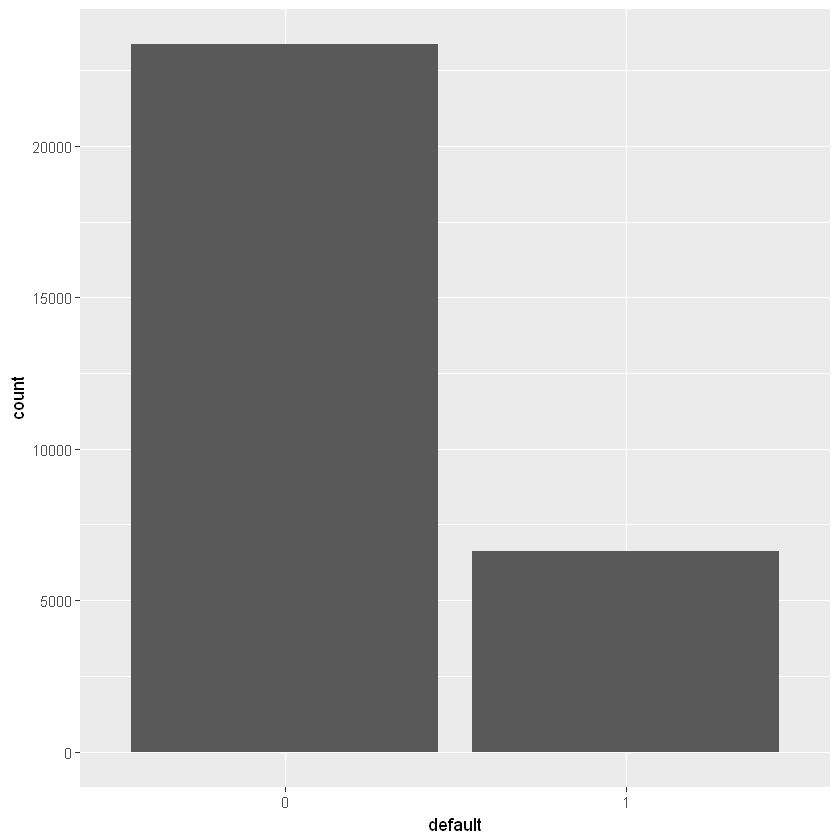

In [3]:
ggplot(defaults, aes(default)) + geom_bar()
cat('proportion of defaults: ', sum(defaults$default==1)/sum(defaults$default==0))

Looks like a bit more than $1/4$ of the sample defaults

As we did before, let's split our data into train-test-validation sets, but this time we are going to use the built in 'createDataPartition' function. This function will automatically balance the splits based on a specified covariate. In this case we are balancing on $default$.

In [4]:
## Splitting the data
trainIndex = createDataPartition(defaults$default, p = .9,
                                  list = FALSE, 
                                  times = 1)
train_test = defaults[trainIndex,]
validation = defaults[-trainIndex,]


To get started we can train a very simple classifier based only on $SEX$, $AGE$, $EDUC$, $MARR$, and $LIMIT$_$BAL$

The simple classifier will use logistic regression. This is very easy to implement in R. The only changes we have to make is to specify "glm" instead of "lm" and change the "family" to binomial.

Let's examine the model.

In [5]:
train1 = cbind(train_test[c('default','SEX','AGE','LIMIT_BAL')],
               select(train_test,starts_with('educ')),
           select(train_test,starts_with('marr')))

# Lets just do a single split here into train-test

tmp = createDataPartition(train1$default, p = .8,
                                  list = FALSE, 
                                  times = 1)
train_tmp = train1[tmp,]
test_tmp = train1[-tmp,]


Logistic = glm(default~., data= train_tmp, family='binomial')       
#GLM (generalized linear model) with family=binomial

summary(Logistic)


Call:
glm(formula = default ~ ., family = "binomial", data = train_tmp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9856  -0.7658  -0.6458  -0.4219   2.6765  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.327e+01  1.015e+02  -0.131   0.8960    
SEX         -1.741e-01  3.407e-02  -5.110 3.22e-07 ***
AGE          3.600e-03  2.077e-03   1.733   0.0831 .  
LIMIT_BAL   -3.237e-06  1.564e-07 -20.694  < 2e-16 ***
educ.._1     1.105e+01  1.015e+02   0.109   0.9133    
educ.._2     1.112e+01  1.015e+02   0.110   0.9128    
educ.._3     1.112e+01  1.015e+02   0.110   0.9128    
educ.._4     9.935e+00  1.015e+02   0.098   0.9220    
educ.._5     9.866e+00  1.015e+02   0.097   0.9226    
educ.._6     1.037e+01  1.015e+02   0.102   0.9187    
marr.._1     1.492e+00  6.024e-01   2.477   0.0132 *  
marr.._2     1.307e+00  6.026e-01   2.169   0.0301 *  
marr.._3     1.482e+00  6.197e-01   2.392   0.0168 *  
---
Signif. codes:  0 '***' 

We can get average marginal effects for all covariates in the model using the margins package. 

The most significant corresponds to the balance limit on the account. 

In [6]:
m = suppressWarnings(margins(Logistic))
summary(m)

factor,AME,SE,z,p,lower,upper
AGE,6.019701e-04,3.472710e-04,1.73343051,8.301918e-02,-7.866850e-05,1.282609e-03
educ.._1,1.848641e+00,1.697729e+01,0.10888904,9.132905e-01,-3.142624e+01,3.512353e+01
educ.._2,1.859216e+00,1.697730e+01,0.10951193,9.127965e-01,-3.141567e+01,3.513410e+01
educ.._3,1.859420e+00,1.697729e+01,0.10952393,9.127869e-01,-3.141546e+01,3.513430e+01
educ.._4,1.661387e+00,1.697744e+01,0.09785850,9.220447e-01,-3.161379e+01,3.493656e+01
educ.._5,1.649890e+00,1.697759e+01,0.09718048,9.225831e-01,-3.162557e+01,3.492535e+01
educ.._6,1.733694e+00,1.697749e+01,0.10211720,9.186636e-01,-3.154157e+01,3.500896e+01
LIMIT_BAL,-5.413791e-07,2.581618e-08,-20.97053200,1.218934e-97,-5.919779e-07,-4.907803e-07
marr.._1,2.495719e-01,1.007226e-01,2.47781528,1.321896e-02,5.215931e-02,4.469845e-01
marr.._2,2.185742e-01,1.007614e-01,2.16922539,3.006558e-02,2.108547e-02,4.160629e-01


Additionally, we can visualize these effects. Let's just examine the effects over the range of $LIMIT$_$BAL$

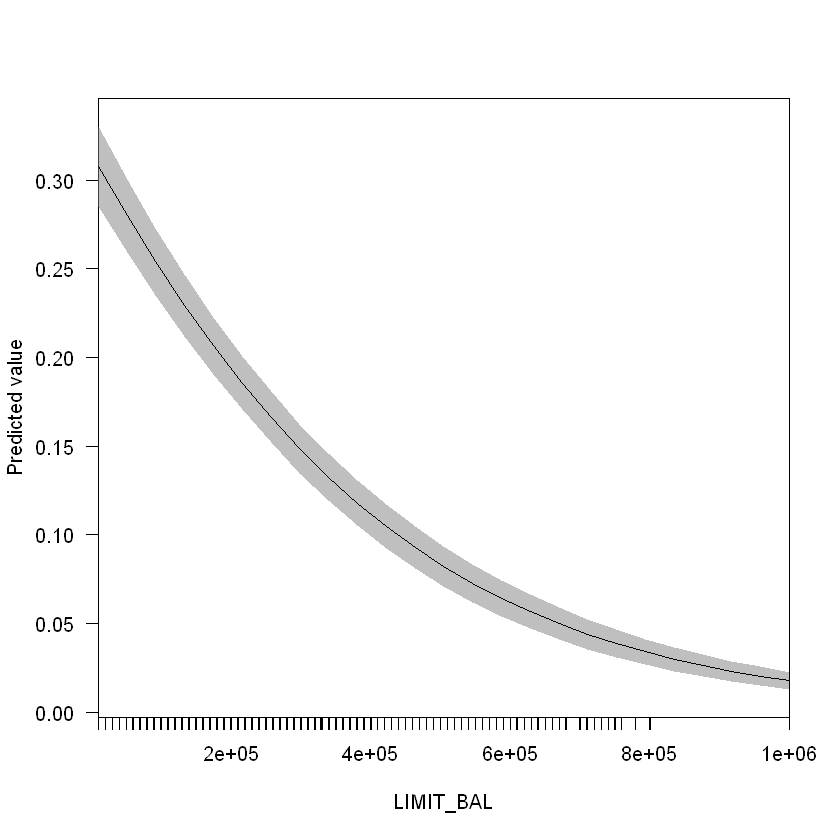

In [7]:
cplot(Logistic, "LIMIT_BAL")

As we expect the probability of default decreases, but at a decreasing rate with the balance limit.

Now let's go ahead and look at the ROC (Receiver operating characteristics) curve. This is really just a way to graph the confusion matrix. The idea is to use sensitivity = True Positives / (True Positives + False Negatives) and specificity = True Negative / (True Negative + False Positive) and plot the tradeoff.

Depending on the scenario in question one may prefer one over the other, but in general one wants to maximize the AUC (area under the curve).

Training AUC:  0.6228948
 Test AUC:  0.6371498

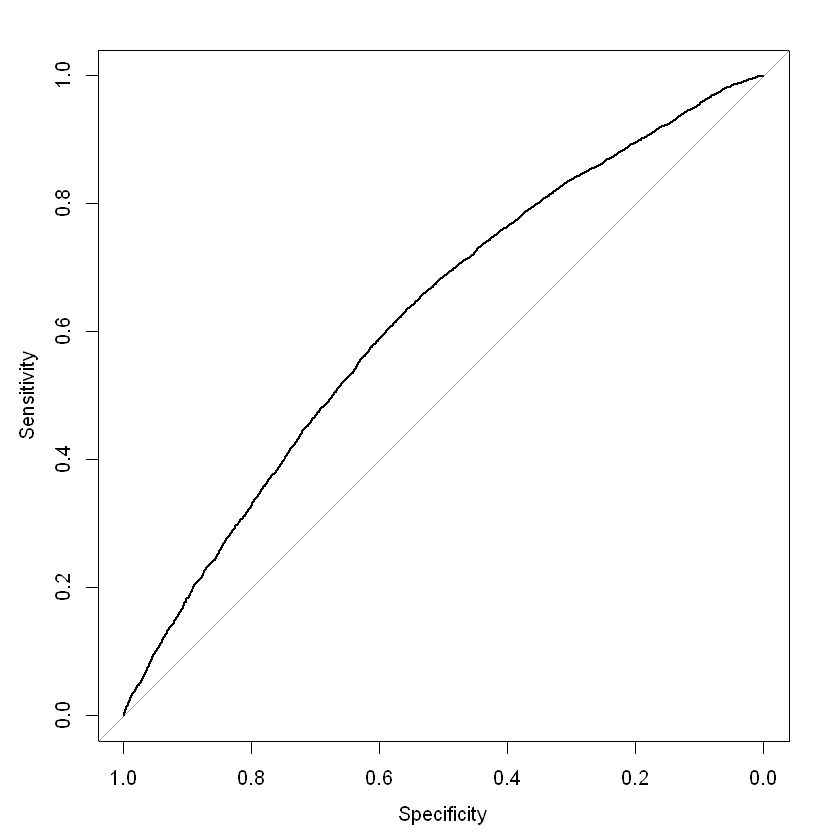

In [8]:
ROC = roc(train_tmp$default,Logistic$fitted.values)
plot(ROC)
cat('Training AUC: ', auc(ROC))

ROC = roc(test_tmp$default,predict(Logistic,newdata = test_tmp))
cat('\n Test AUC: ', auc(ROC))

The simple classifier doesn't do too poorly. Training and test set performance are about the same, but we should be able to obtain better performance by including the remaining covariates.

Add the covariates relating to past payment and bill balances using the select() command and run the new regression model.

In [9]:
train2 = cbind(train1,select(train_test,starts_with('PAY')),
               select(train_test,starts_with('BILL')))

tmp = createDataPartition(train2$default, p = .8,
                                  list = FALSE, 
                                  times = 1)
train_tmp = train2[tmp,]
test_tmp = train2[-tmp,]

Logistic = glm(default~., data= train_tmp, family='binomial')

How does our ROC improve by adding these covariates?

Training AUC:  0.7283954
 Test AUC:  0.7147754

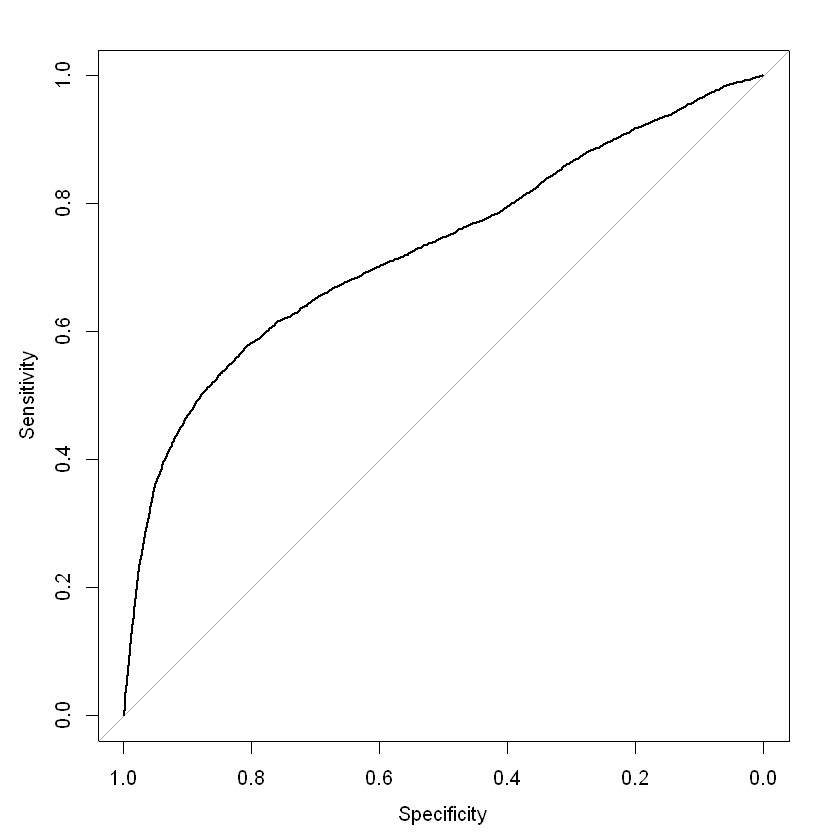

In [10]:
ROC = roc(train_tmp$default,Logistic$fitted.values)
plot(ROC)
cat('Training AUC: ', auc(ROC))

ROC = roc(test_tmp$default,predict(Logistic,newdata = test_tmp))
cat('\n Test AUC: ', auc(ROC))


Looks like adding the additional information helped quite a bit. However, we may be interested in other functional forms for the model.

There are many options for flexible functional forms. The most common way is to add higher order terms (polynomials) as we did in the first module.

Another common method is to use a cubic spline. 

Let's consider a very simple extension of the previous model. The only difference will be the $LIMIT$_$BAL$ variable enters the model as an argument of an unknown function. The extension of GLM in this form is called a GAM (Generalized Additive Model)

In R we can use the GAM package to estimate these types of models. One thing to keep in mind is the formula must be specified here. The model we are looking at is exactly the same as the previous one except we apply a cubic spline to $LIMIT$_$BAL$. This is denoted by "s()" with the option set to "cr".

In [11]:
formula = as.formula(paste("default~", paste(colnames(train2[, !names(train2) %in% 
                                                     c("default","LIMIT_BAL")]), 
                                     collapse="+"),'+s(LIMIT_BAL, bs="cr")'))

Logistic = gam(formula, data= train_tmp, family='binomial')
summary(Logistic)



Family: binomial 
Link function: logit 

Formula:
default ~ SEX + AGE + educ.._1 + educ.._2 + educ.._3 + educ.._4 + 
    educ.._5 + educ.._6 + marr.._1 + marr.._2 + marr.._3 + PAY_0 + 
    PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6 + PAY_AMT1 + PAY_AMT2 + 
    PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6 + BILL_AMT1 + BILL_AMT2 + 
    BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6 + s(LIMIT_BAL, 
    bs = "cr")

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.389e+01  1.683e+04  -0.001  0.99887    
SEX         -9.630e-02  3.654e-02  -2.636  0.00839 ** 
AGE          4.510e-03  2.199e-03   2.051  0.04026 *  
educ.._1     2.129e+01  1.683e+04   0.001  0.99899    
educ.._2     2.127e+01  1.683e+04   0.001  0.99899    
educ.._3     2.126e+01  1.683e+04   0.001  0.99899    
educ.._4     2.059e+01  1.683e+04   0.001  0.99902    
educ.._5     1.990e+01  1.683e+04   0.001  0.99906    
educ.._6     2.113e+01  1.683e+04   0.001  0.99900    
marr.._1     1.45

Notice that $LIMIT$_$BAL$ is now described at the end of summary and is called a "smooth term"

We can once again evaluate the ROC curve for this model.

Training AUC:  0.7289298
 Test AUC:  0.7144263

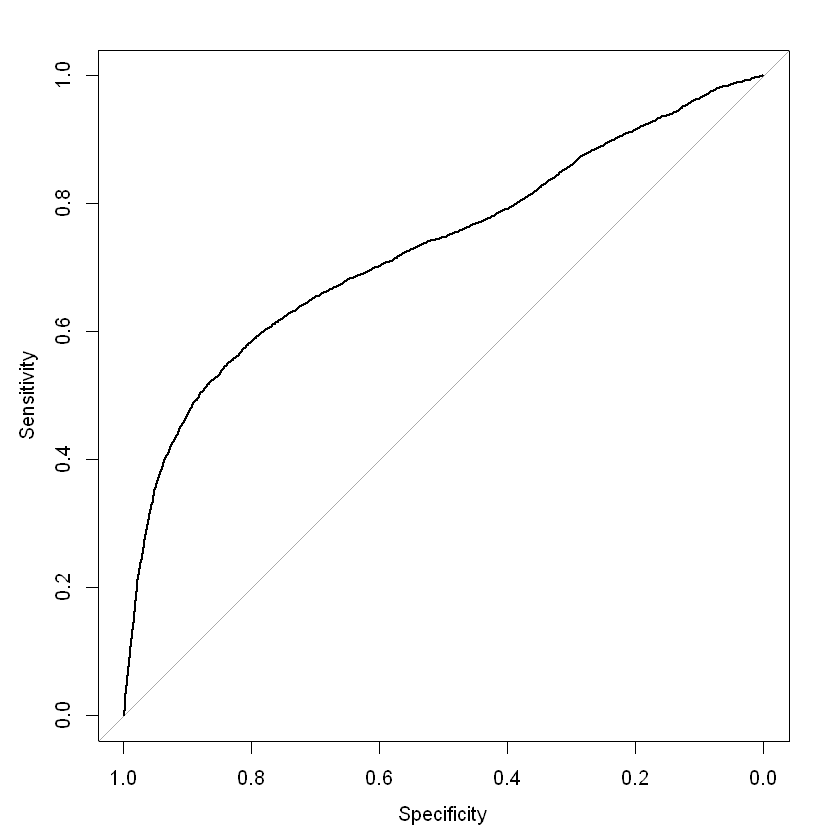

In [12]:
ROC = roc(train_tmp$default,Logistic$fitted.values)
plot(ROC)
cat('Training AUC: ', auc(ROC))

ROC = roc(test_tmp$default,predict(Logistic,newdata = test_tmp))
cat('\n Test AUC: ', auc(ROC))



We get a slight improvement in test performance in this case. One caveat to adding smoothing terms to the model is that they  can overfit. There are various ways of handling this, but penalization can and is used in this setting as well.

Let's just go back to our model without the smooth terms to see that penalized regression is easily extended to the GLM family.

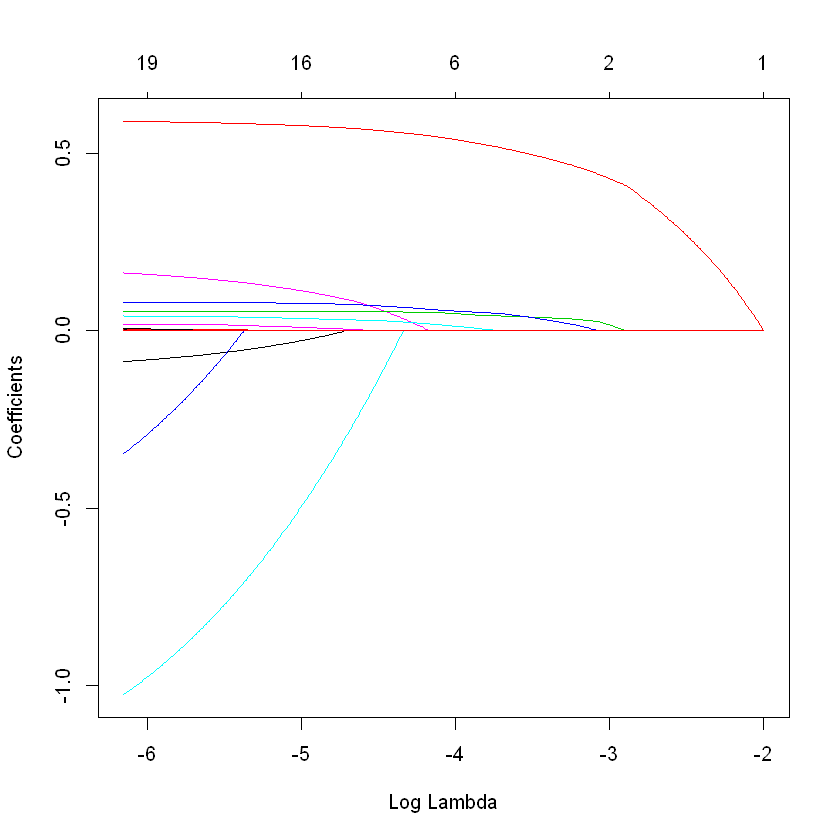

In [13]:
y = as.double(as.matrix(train_tmp$default))                                     
x = as.matrix(train_tmp[,-1])


cv.lasso = cv.glmnet(x, y, family='binomial', alpha=1, nfolds=5, nlambda=1000)             
plot(cv.lasso$glmnet.fit, xvar="lambda")                                    


Training AUC:  0.7150328
 Test AUC:  0.7174447

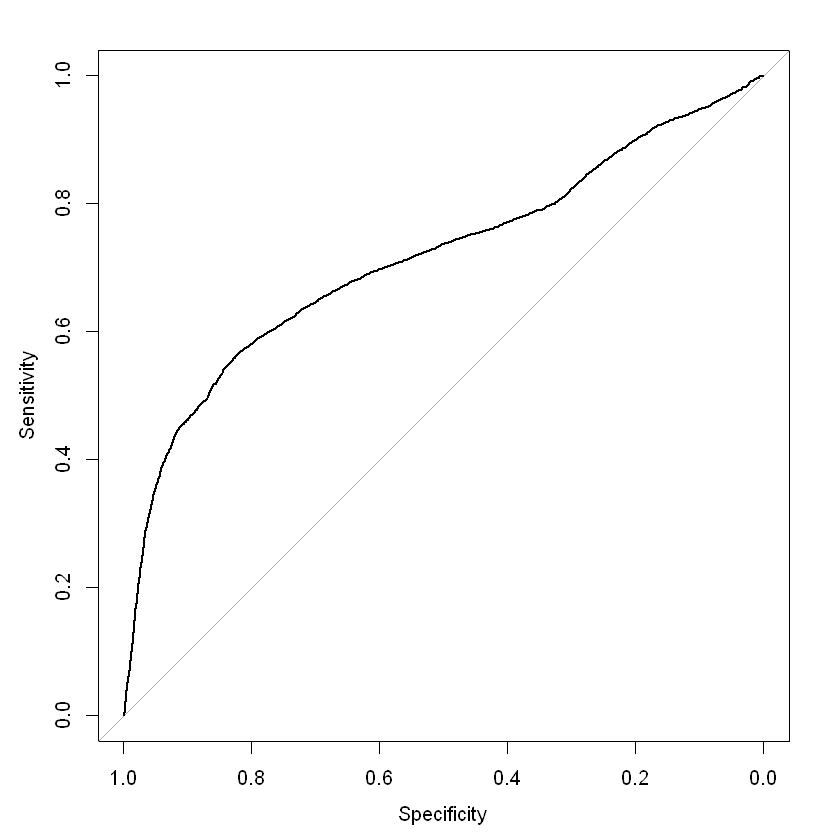

In [18]:
ROC = roc(train_tmp$default,c(predict(cv.lasso,newx=x)))
plot(ROC)
cat('Training AUC: ', auc(ROC))


xtest = as.matrix(test_tmp[,-1])
ytest = as.double(as.matrix(test_tmp$default))
ROC = roc(test_tmp$default,c(predict(cv.lasso,newx=xtest)))
cat('\n Test AUC: ', auc(ROC))



EXERCISES:

Redo the Lasso regression with a subsample of the data where the default rate is much lower ($0.5\%$).